In [68]:
import numpy as np
import h5py
import cv2
import glob
import matplotlib.pyplot as plt
import time
import matplotlib.patches as patches

# Evaluation 

In [69]:
def visualise_goal_vs_path(start,goal,poses,legend_pos="upper right"):
    '''
    Visualise the goal path and the path taken
    
    
    '''

    start_x=start[0]
    start_y=start[1]    
    goal_x=goal[0]
    goal_y=goal[1]
    path_x=poses[:,0]
    path_y=poses[:,1]
    fig, ax = plt.subplots()
    circle = patches.Circle((goal_x, goal_y),1.0, edgecolor='orange', facecolor='none', linewidth=2,label="Tolerance (1m)")
    ax.add_patch(circle)
    ax.plot(start_x,start_y,'ro',label="Start")
    ax.plot(goal_x,goal_y,'go',label="Goal")
    ax.plot(path_x,path_y,'-b',label="Path")
    ax.set_xlabel('X coordinate (m)')
    ax.set_ylabel('Y coordinate (m)')
    plt.axis('equal')
    plt.grid()
    plt.title('Goal vs Path Relative to Starting Position')
    plt.legend(loc=legend_pos)
    plt.show()



def visualise_target_vs_iters(targets):
    '''
    Visualise the goal path and the path taken
    
    
    '''
    abs_targets=np.ones(shape=(len(targets),1))
    abs_targets[:,0]=np.square(np.sum(targets[:,0:1],axis=1))   
    abs_targets[:,0]=np.sqrt(abs_targets[:,0])   
    plt.plot(abs_targets,'-b',label="path")
    plt.xlabel('Time (s)')
    plt.ylabel('Radial distance from goal (m)')
    plt.title('Radial distance from goal vs time')
    plt.grid()
    plt.show()


def visualise_comaparison(start,goal,expert_traj,agent_traj,legend_pos="upper right"):
    '''
    Comaprea expert and agent traj
    
    '''

    start_x=start[0]
    start_y=start[1]    
    goal_x=goal[0]
    goal_y=goal[1]
    path_x=expert_traj[:,0]
    path_y=expert_traj[:,1]
    path_x_agent=agent_traj[:,0]
    path_y_agent=agent_traj[:,1]
    fig, ax = plt.subplots()
    circle = patches.Circle((goal_x, goal_y),1.0, edgecolor='orange', facecolor='none', linewidth=2,label="Tolerance (1m)")
    ax.plot(start_x,start_y,'ro',label="Start")
    ax.plot(goal_x,goal_y,'go',label="Goal")
    ax.plot(path_x,path_y,'-b',label="Path of expert")
    ax.plot(path_x_agent,path_y_agent,'-m',label="Path of agent")
    ax.set_xlabel('X coordinate (m)')
    ax.set_ylabel('Y coordinate (m)')
    plt.axis('equal')
    plt.grid()
    plt.title('Path Taken by Expert vs Agent Relative to Starting Position')
    plt.legend(loc=legend_pos)
    plt.show()
    
    
    # plt.plot(start_x,start_y,'ro',label="start")
    # plt.plot(goal_x,goal_y,'go',label="goal")
    # plt.plot(path_x,path_y,'-b',label="path of expert")
    # plt.plot(path_x_agent,path_y_agent,'-m',label="path of agent")
    # plt.xlabel('X coordinate (m)')
    # plt.ylabel('Y coordinate (m)')
    # plt.grid()
    # plt.axis('equal')
    # plt.title('Path Taken by Expert vs Agent Relative to Starting Position')
    # plt.legend(loc=legend_pos)
    # plt.show()

def read_dataset(file_path):
    '''
    Read the data files from the dataset
    '''
    read_file= h5py.File(file_path, "r")
    batch_size= read_file['kris_dynamics']['odom_data']['target_vector'].shape[0]
    rgbs=[]
    depths=[]
    targets=[]  
    acts=[]
    for i in range(batch_size):
        target=read_file['kris_dynamics']['odom_data']['target_vector'][i]
        rgb=read_file['images']['rgb_data'][i]
        depth=read_file['images']['depth_data'][i]
        act=read_file['kris_dynamics']['odom_data']['odom_data_wheel'][i]    
        ## If visualisation is needed
        # if visualise_img:
        #     visualise(rgb_features,depth_features)  
        rgbs.append(rgb)
        depths.append(depth)
        targets.append(target) 
        acts.append(act)

    acts=np.array(acts[:-1])
    rgbs=np.array(rgbs)
    depths=np.array(depths)
    targets=np.array(targets)

    return acts,targets

In [70]:
# File paths
expert_file='../GailNavigationNetwork/data/trajectories/medium_world/traj5.hdf5'
agent_file='../GailNavigationNetwork/data/trajectories/tests/hard_world/test1.hdf5'

#Variables of expert
acts_expert,targets_expert=read_dataset(expert_file)
acts_expert=acts_expert[:,:2]
targets_expert=targets_expert[:,:2]
# print(f"acts shape is {acts_expert.shape} first one is {acts_expert[0]} \n shape is {targets_expert.shape} first one is {targets_expert[0]}")
starting_pose=acts_expert[0]
goal_pose=acts_expert[-1]
print(f"Expert demo Starting pose is {starting_pose} and goal_pose is {goal_pose}")
# "{header: {frame_id: 'odom'}, pose: {position: {x: 10.11 , y : 7.51}}}" --once
#Variables of agent

# acts_agent,targets_agent=read_dataset(agent_file)
# acts_agent=acts_agent[:,:2]
# targets_agent=targets_agent[:,:2]
# print(f"acts shape is {acts_agent.shape} first one is {acts_agent[0]} \n shape is {targets_agent.shape} first one is {targets_agent[0]}")


Expert demo Starting pose is [15.34021451  9.34609276] and goal_pose is [10.76181651 14.38067009]


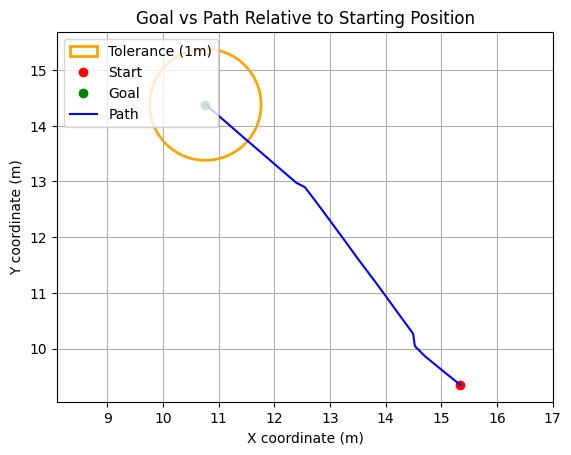

In [71]:
visualise_goal_vs_path(starting_pose,goal_pose,acts_expert,"upper left")

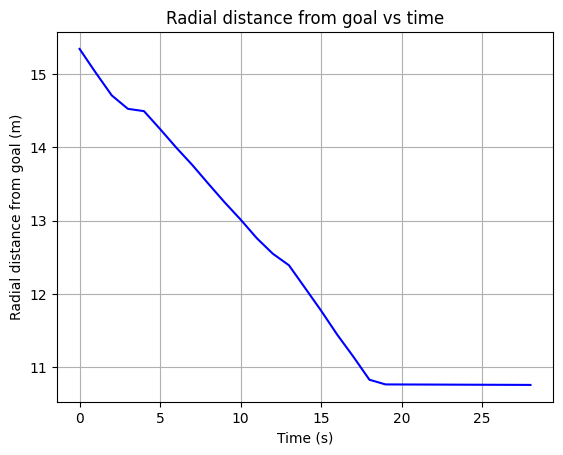

In [72]:
visualise_target_vs_iters(targets=acts_expert)

In [73]:
visualise_comaparison(starting_pose,goal_pose,acts_expert,acts_agent,"upper left")

NameError: name 'acts_agent' is not defined